In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.linalg import expm, fractional_matrix_power

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

from sklearn.metrics import adjusted_mutual_info_score as ami

from scipy.stats import zscore

from tqdm.auto import tqdm

import networkx as nx
#from networkx.community import louvain_communities
import igraph as ig

from utils.Multiscale.load_data import load_dict
from utils.Multiscale.multiscale_functions import laplacian_matrix
from netneurotools import plotting, cluster
from netneurotools.metrics import communicability_bin, communicability_wei

import utils.CommonFunctions as cf
import utils.plotter as plotter

from utils import distance

# Data visualization

In [2]:
data = load_dict('data/LAU1000')

In [3]:
data['sc'].shape

(1000, 1000)

(1000, 1000)

In [4]:
data.keys()

dict_keys(['sc', 'fc', 'coords', 'lhannot', 'rhannot', 'noplot', 'order', 'rsn', 'rsn_names', 've', 've_names', 'ci'])

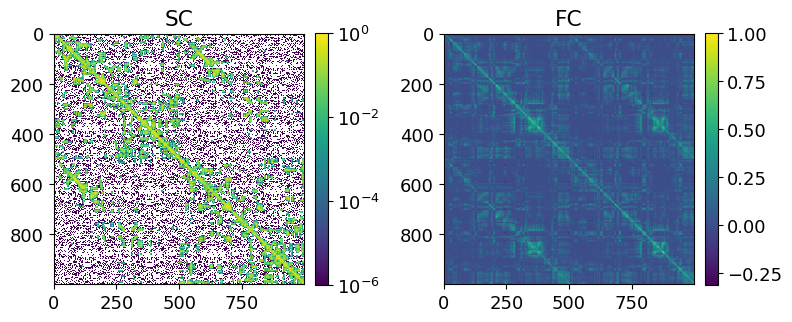

In [5]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,2,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.tight_layout()
plt.show()

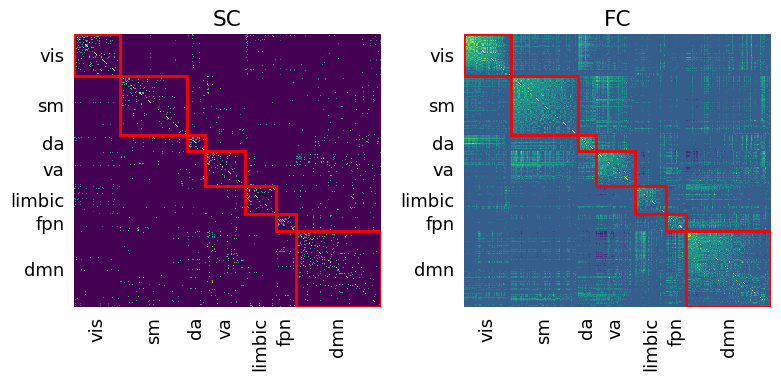

In [27]:
plt.figure(figsize=(8,4))

ax1 = plt.subplot(1,2,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax1, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax2 = plt.subplot(1,2,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax2, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

plt.tight_layout()
plt.show()

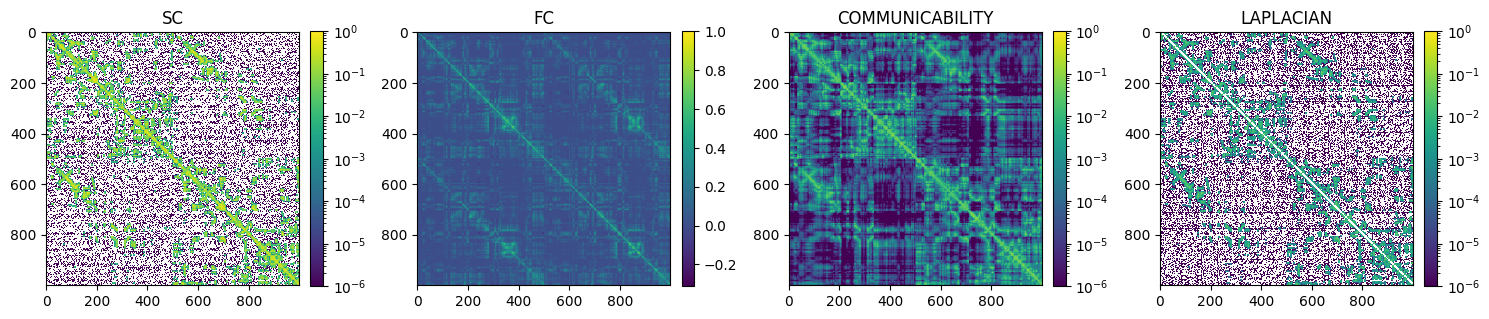

In [10]:
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(communicability_wei(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.subplot(1,4,4)
plt.imshow(-laplacian_matrix(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('LAPLACIAN')

plt.tight_layout()
plt.show()

# Only left hemisphere

In [98]:
sc = data['sc']
N = sc.shape[0]
sc_left = sc[:N//2,:N//2]

communicability_left = communicability_wei(sc_left)
communicability_left = (communicability_left + communicability_left.T) / 2

comms_emp = data['rsn'] -1
comms_left = comms_emp[:N//2]

In [78]:
# Normalize matrix
adjacency = sc_left.copy()
row_sum = adjacency.sum(1)
neg_sqrt = np.power(row_sum, -0.5)
square_sqrt = np.diag(neg_sqrt)

# normalize input matrix
for_expm = square_sqrt @ adjacency @ square_sqrt

# Normalize by in-degree
sc_left_norm = sc_left / np.sum(sc_left, axis=1)[:,None]

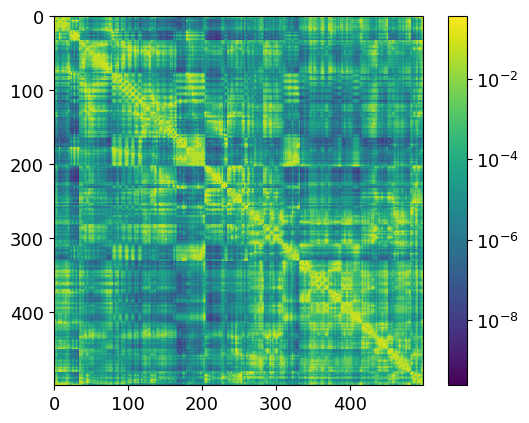

In [8]:
plt.imshow(communicability_left, norm=LogNorm())
plt.colorbar()
plt.show()

# Community detection
see https://igraph.org/python/api/develop/igraph.community.html for clustering methods <br>
see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for evaluation metrics

In [10]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score

In [11]:
def community_detection(mat, method, *args):
    graph = ig.Graph.Weighted_Adjacency(mat.tolist(), mode=ig.ADJ_UNDIRECTED, attr="weight", loops=False)
    
    if method == 'louvain':
        comms = graph.community_multilevel(weights=graph.es['weight'], return_levels=False)
    elif method == 'leiden':
        if len(args)>0:
            resolution = args[0]
        else:
            resolution = 1
        comms = graph.community_leiden(weights=graph.es['weight'], resolution=resolution, n_iterations=-1, objective_function='modularity') #objective_function: Constant Potts Model (CPM) or modularity
    elif method == 'spin_glass':
        comms = graph.community_spinglass(weights=graph.es['weight'], spins=int(1e3))
    elif method == 'infomap':
        comms = graph.community_infomap(edge_weights=graph.es['weight'], trials=10)
    else:
        raise( Exception('Community detection method not defined.\n'))
    
    return comms.membership

def metrics(comms_true, comms_emp, method):
    if method == 'nmi':
        score = normalized_mutual_info_score(comms_true, comms_emp)
    elif method == 'ami':
        score = adjusted_mutual_info_score(comms_true, comms_emp)
    elif method == 'ari':
        score = adjusted_rand_score(comms_true, comms_emp)
    else:
        raise(Exception('Evaluation method not defined.\n'))
    
    return score

In [12]:
scales = np.logspace(-1,1,20)

comms_sc = [community_detection(sc_left, 'leiden', scale) for scale in scales]
comms_comm = [community_detection(communicability_left, 'leiden', scale) for scale in scales]

In [13]:
sc_score = [ami(tmp, comms_left) for tmp in comms_sc]
comm_score = [ami(tmp, comms_left) for tmp in comms_comm]

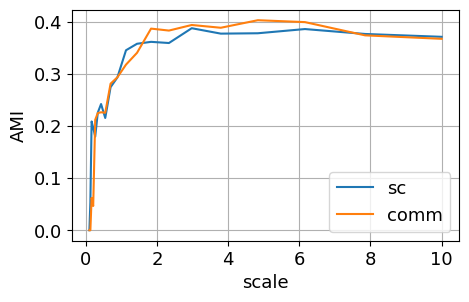

In [14]:
plt.figure(figsize=(5,3))

plt.plot(scales, sc_score, label='sc')
plt.plot(scales, comm_score, label='comm')
plt.xlabel('scale')
plt.ylabel('AMI')
plt.grid()
plt.legend()
plt.show()

# Diffusion distance

In [18]:
res = distance.diffusion_distance(sc_left, args=[1, 0.1], name='sc_left', title=None, comms=None, show=False)

DIFFUSION DISTANCE
- Compute laplacian...
1 0.1
- Compute average distance...


  0%|          | 0/500 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


# 

# Jacobian distance

In [88]:
dynamics = 'Neuronal'

B = 1
#C = 0

#Cs = [0.1, 0, -0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]
#Cs = [0.1]
#Rs = [0.08, 0.06]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]
Cs = [0.]
Rs = [0.005, 0.001]

params = [[B, C, R] for C in Cs for R in Rs]
print(params)

[[1, 0.0, 0.005], [1, 0.0, 0.001]]


JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.0, 0.005]


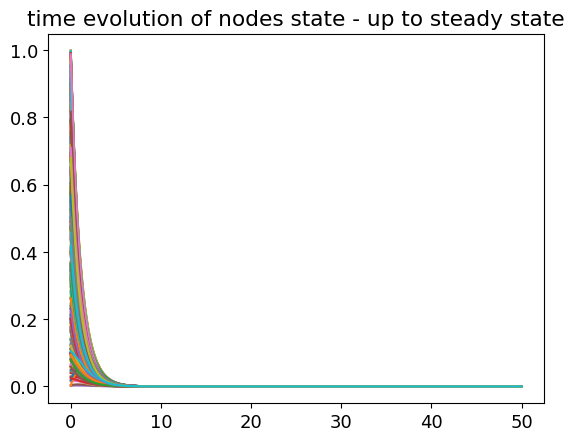

[1, 0.0, 0.005]
Normalizing jacobian - $\lambda_{max}$=1.0540177246680233
- Compute average distance...


  0%|          | 0/500 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.0, 0.001]


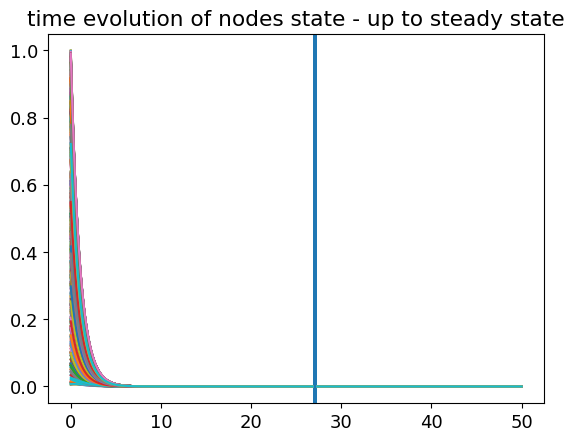

[1, 0.0, 0.001]
Normalizing jacobian - $\lambda_{max}$=1.010803544933609
- Compute average distance...


  0%|          | 0/500 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


In [89]:
res_all = []

for param in params:
    res = distance.jacobian_distance(sc_left_norm, dynamics, norm=True, args=param, name='sc_left_normalized', title=None, comms=None, show=False)
    res_all.append(res)

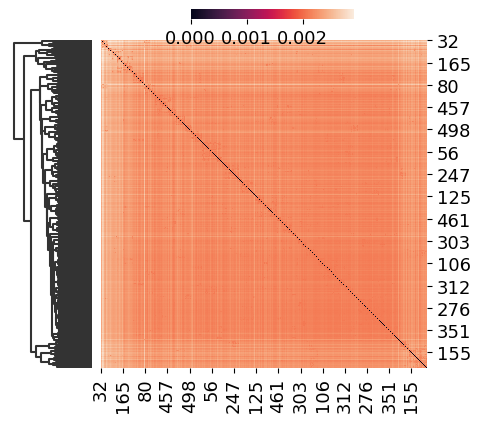

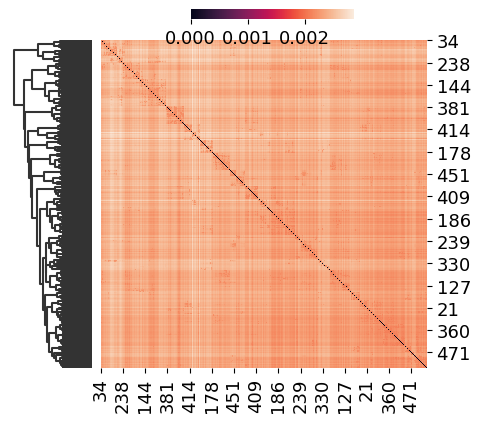

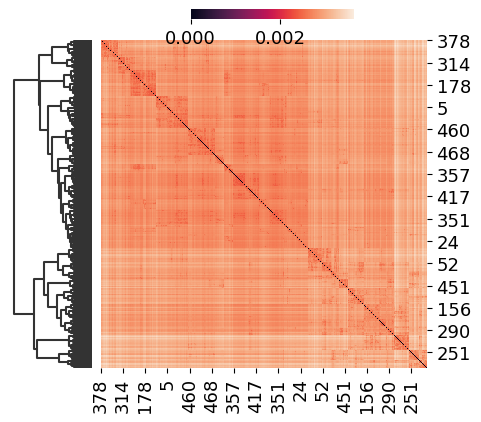

In [150]:
for i, res in enumerate(res_all):
    plotter.plot_clustermap(res[0], figsize=(5,5), cmap)

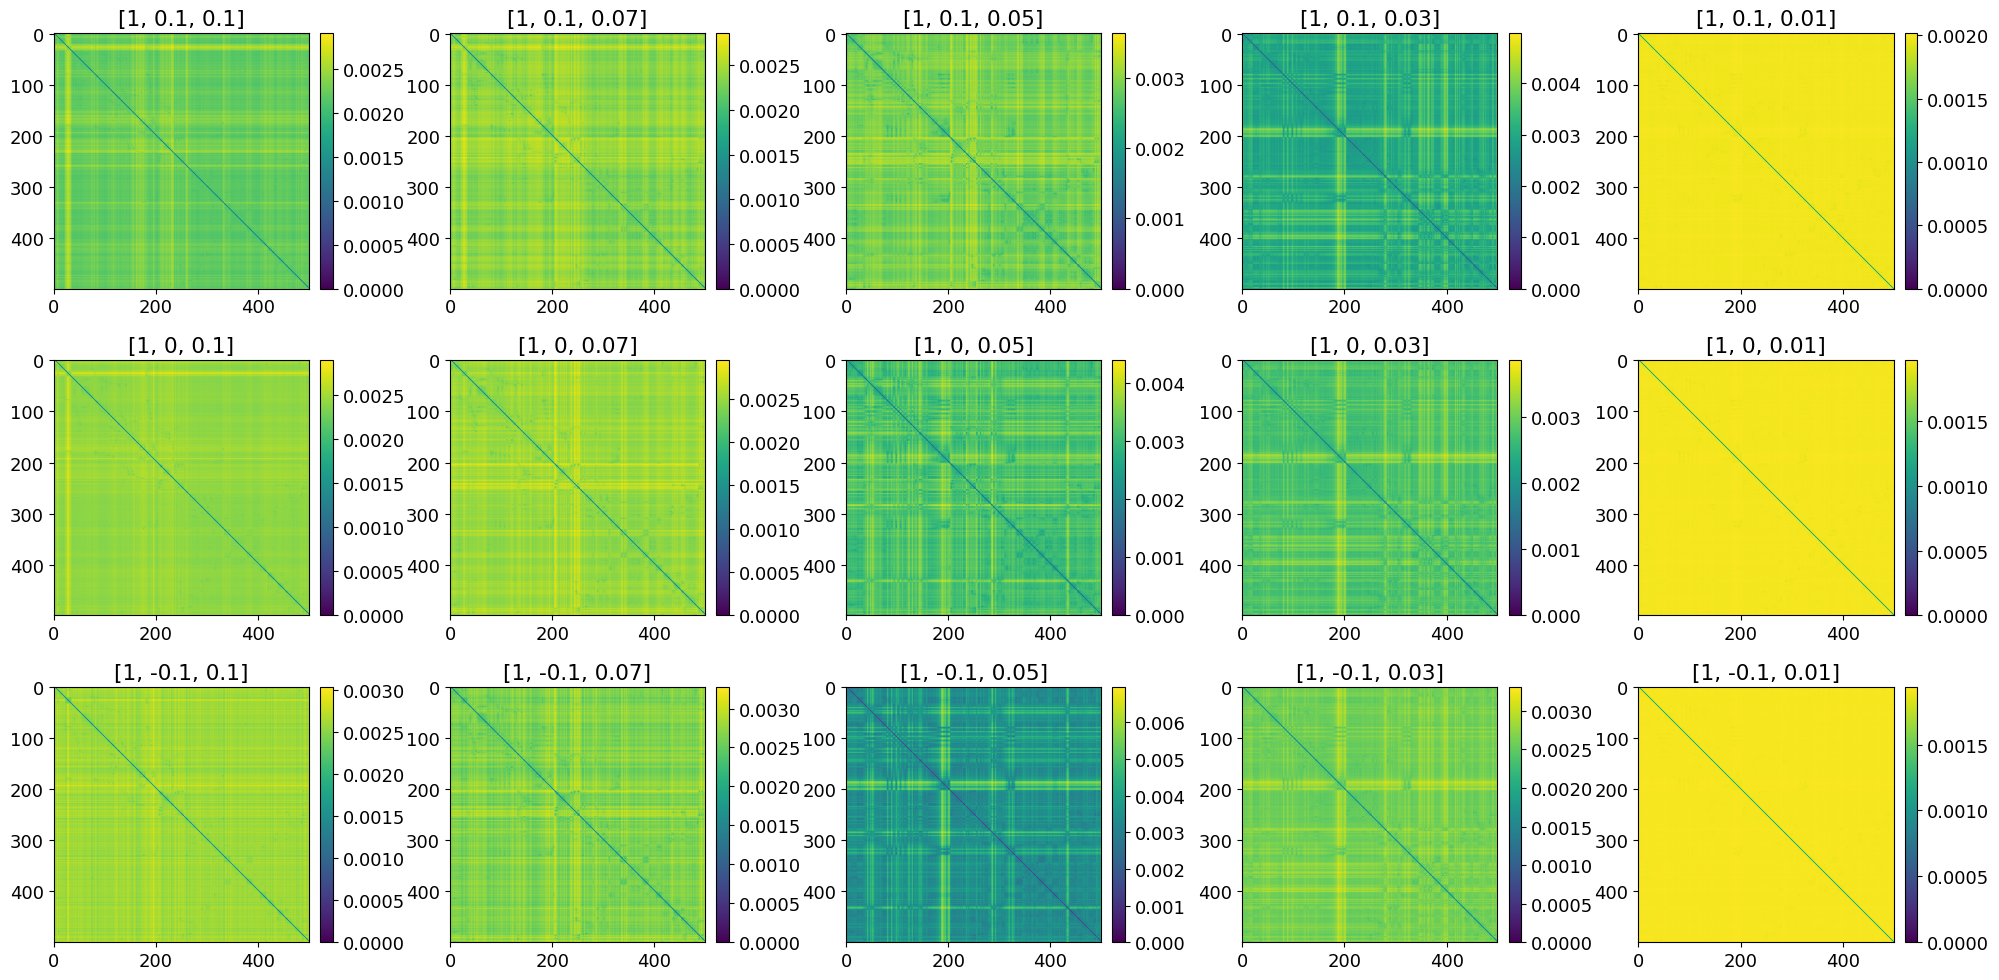

In [140]:
plt.figure(figsize=(20,10))

for i, res in enumerate(res_all):
    plt.subplot(len(Cs),len(Rs),i+1)
    im = plt.imshow(res[0])
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.title(params[i])
    
plt.tight_layout()
plt.show()

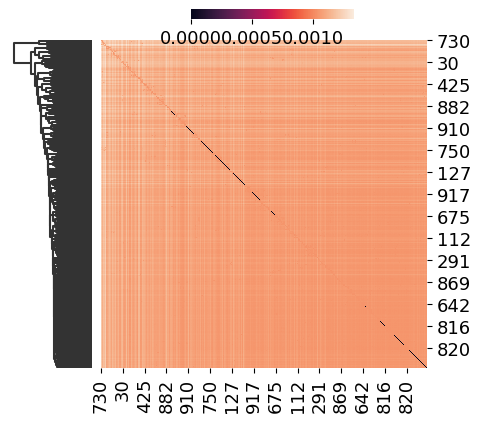

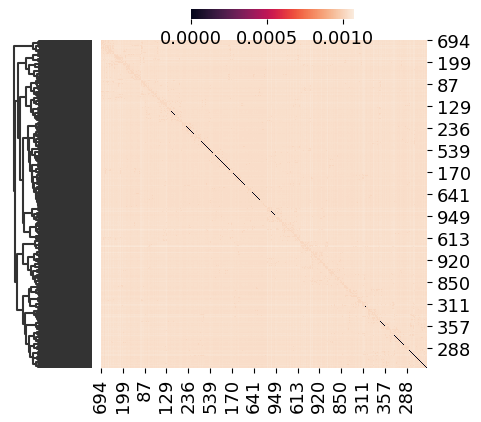

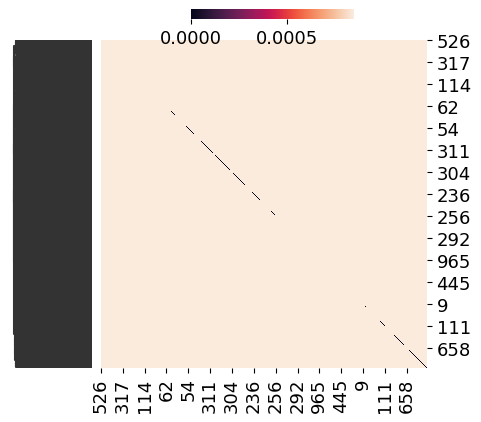

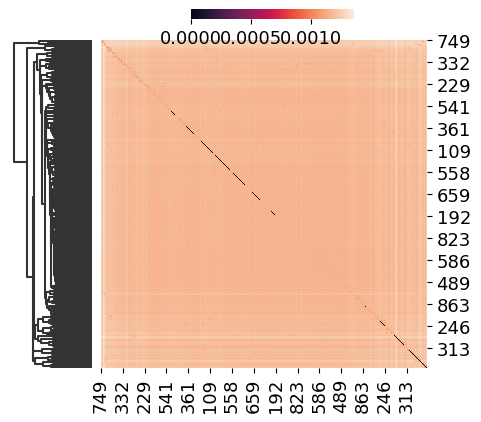

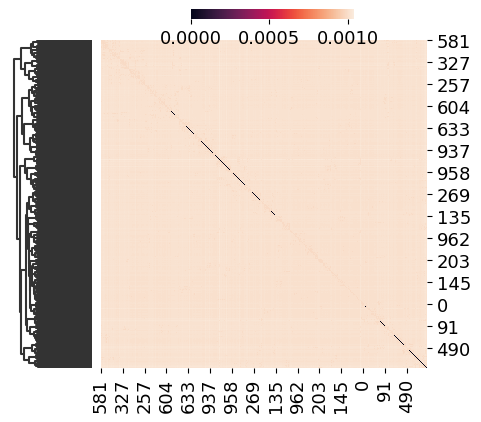

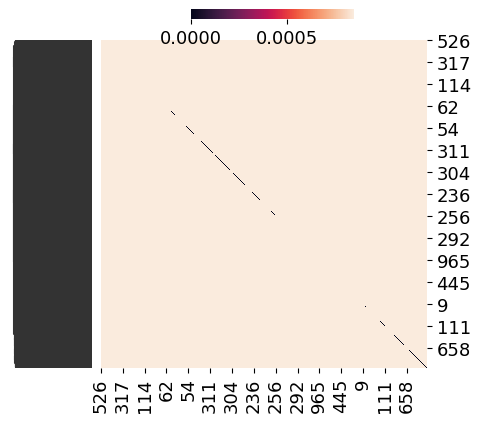

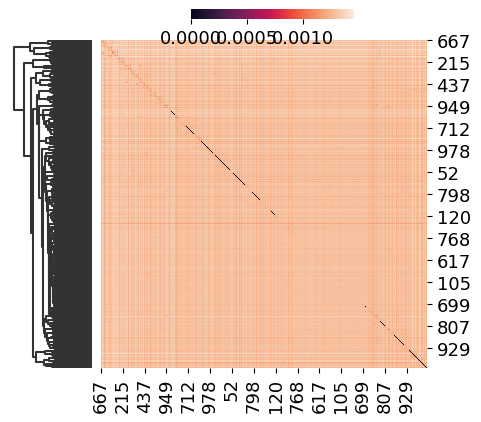

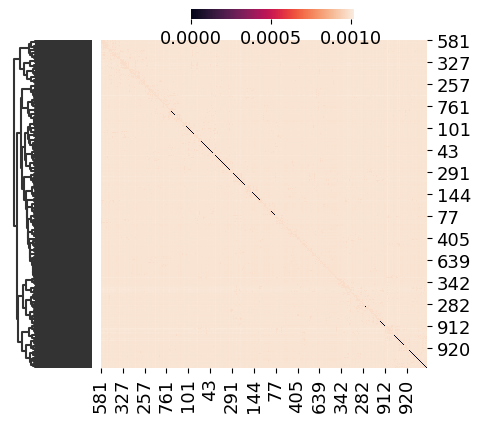

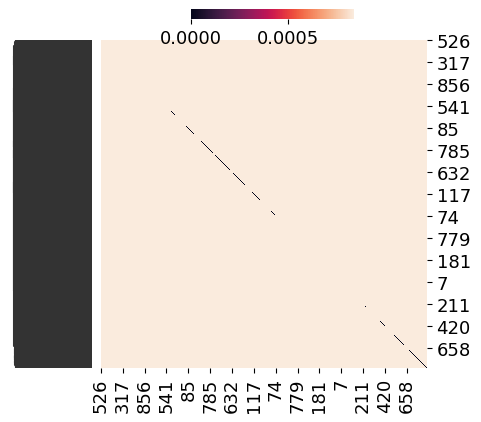

In [12]:
for i, res in enumerate(res_all):
    plotter.plot_clustermap(res[0], figsize=(5,5))

# Load the results

In [24]:
diff = np.loadtxt('results/diffusion_sc_left.txt')

In [90]:

B = 1

#Cs = [0.1, 0, -0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

Cs = [0.]
Rs = [0.005, 0.001]

params = [[B, C, R] for C in Cs for R in Rs]
print(params)

res_all = [np.loadtxt(f'results/Neuronal_{param}_sc_left_normalized.txt') for param in params]

[[1, 0.0, 0.005], [1, 0.0, 0.001]]


In [91]:
ncomms = np.arange(2,100)

### Compute dendrogram
mylinkage = linkage(squareform(diff), method='average')
### Compute communities = cut dendrogram
comms = [fcluster(mylinkage, criterion='maxclust', t=t) for t in ncomms]
    
### Compute index
infos_diff = [ami(tmp, comms_left) for tmp in comms]

# Compute community detection

In [92]:
ncomms = np.arange(2,100)

infos = np.zeros((len(params),len(ncomms)))

for i, res in enumerate(res_all):
    ### Compute dendrogram
    mylinkage = linkage(squareform(res), method='average')
    ### Compute communities = cut dendrogram
    comms = [fcluster(mylinkage, criterion='maxclust', t=t) for t in ncomms]
    
    #to_print = [ np.unique(tmp, return_counts=True)[1].max() for tmp in comms]
    #print(to_print)
    
    ### Compute index
    infos[i] = [ami(tmp, comms_left) for tmp in comms]

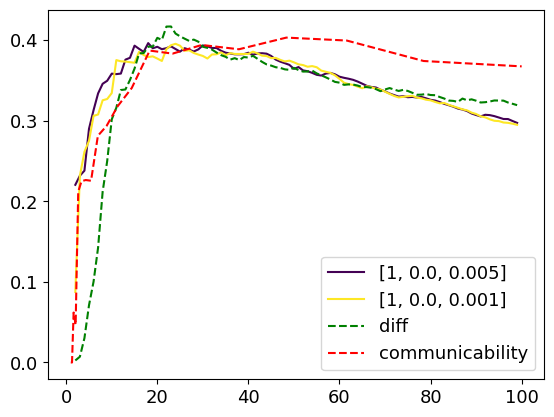

In [97]:
cmap = plt.get_cmap('viridis', len(params))

for i, info in enumerate(infos):
    plt.plot(ncomms, info, label=params[i], c=cmap(i))
    
plt.plot(ncomms, infos_diff, '--', label='diff', c='green')
plt.plot(scales*10, comm_score, '--', label='communicability', c='red')
plt.legend()
plt.show()

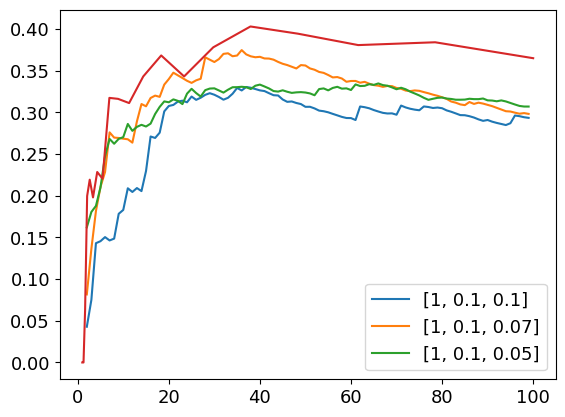

In [162]:
for i, info in enumerate(infos[:10]):
    plt.plot(ncomms, info, label=params[i])
plt.plot(scales*10, comm_score)
plt.legend()
plt.show()

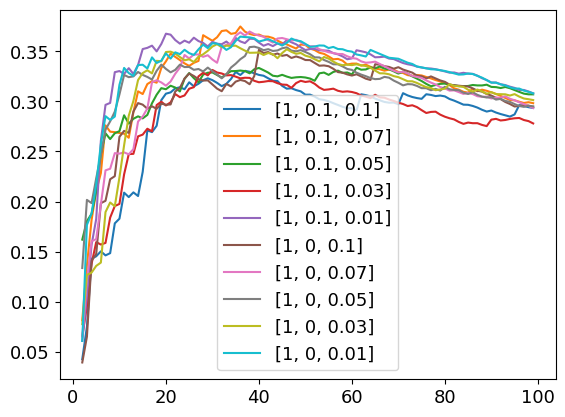

In [146]:
for i, info in enumerate(infos[:10]):
    plt.plot(ncomms, info, label=params[i])
plt.legend()
plt.show()